# 20-12-2019
## Visualize personal Gmail inbox traffic over time

In [1]:
import mailbox, pandas as pd, numpy as np 
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from dateutil.parser import parse as parse_datetime
%matplotlib inline

In [2]:
#define the fonts to use for plots
family = 'ZING RUST'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')

### Load the Gmail archive and parse dates/times from messages¶

In [3]:
# load the mbox file
path = 'C:/Users/CRRITDEPT/Desktop/Takeout/Mail/mail.mbox'
mbox = mailbox.mbox(path)
print('There are {:,} messages in the archive.'.format(len(mbox)))

There are 2,095 messages in the archive.


The Gmail mbox file includes emails and hangouts chats among its "messages". Hangouts messages don't have date/time, so we'll only parse dates and times from the actual emails, and just ignore the hangouts chats. Also, some chats do have a date. To filter them out, verify that if the message has a label that the label does not include "Chat".

In [4]:
# get a list of the dates/times of all the messages in the mbox
all_dates = []
all_times = []
for message in mbox:
    # it's an email and not a chat if there's no label, or if there's a label but it's not 'chat'
    if not 'X-Gmail-Labels' in message or ('X-Gmail-Labels' in message and not 'Chat' in message['X-Gmail-Labels']):
        if 'Date' in message and message['Date'] is not None:
            try:
                date, time = str(parse_datetime(message['Date'])).split(' ')
            except Exception as e:
                print(e, message['Date'])
            all_dates.append(date)
            all_times.append(time)
        else:
            # hangouts messages have no Date key, so skip them
            pass
print('There are {:,} messages with dates.'.format(len(all_dates)))

There are 1,520 messages with dates.


### Plot the Gmail traffic by date

In [7]:
# get the count per date
date_counts = pd.Series(all_dates).value_counts().sort_index()
print('There are {:,} dates with messages.'.format(len(date_counts)))
date_counts.head()

There are 482 dates with messages.


2017-07-26    3
2017-08-05    1
2017-08-11    1
2017-08-12    1
2017-08-16    1
dtype: int64

In [8]:
# not every date necessarily has a message, so fill in missing dates in the range with zeros
date_range = pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')
index = date_range.map(lambda x: str(x.date()))
date_counts = date_counts.reindex(index, fill_value=0)

print('There are {:,} dates total in the range, with or without messages.'.format(len(date_counts)))
date_counts.head()

There are 877 dates total in the range, with or without messages.


2017-07-26    3
2017-07-27    0
2017-07-28    0
2017-07-29    0
2017-07-30    0
dtype: int64

In [10]:
[i for i in range(11) if i % 2 == 0]

[0, 2, 4, 6, 8, 10]

In [11]:
[i if i%2 == 0 else i*3 for i in range(11)]

[0, 3, 2, 9, 4, 15, 6, 21, 8, 27, 10]

In [9]:
# create a series of labels for the plot: each new year's day
xlabels = pd.Series([label if '01-01' in label else None for label in date_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]
xlabels.head()

159    2018-01-01
524    2019-01-01
dtype: object

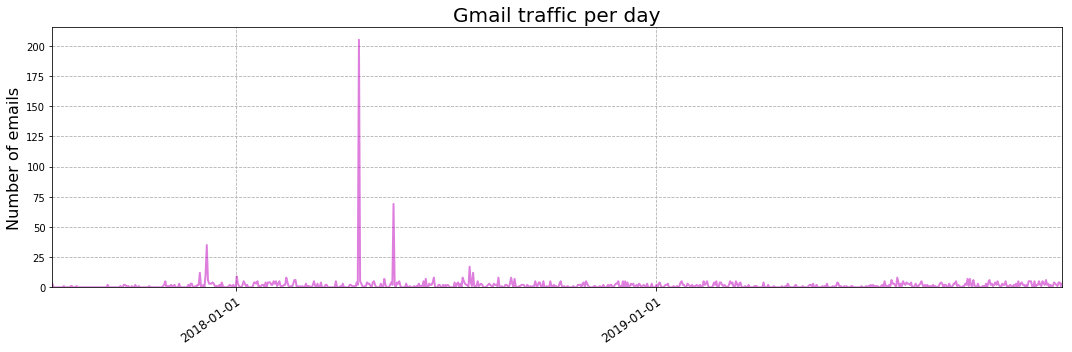

In [14]:

# plot the counts per day
fig = plt.figure(figsize=[15, 5])
ax = date_counts.plot(kind='line', linewidth=2, alpha=0.5, color='m')

ax.set_ylim(bottom=0)
ax.grid(True, linestyle='--')
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', 
                   ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Gmail traffic per day', fontproperties=title_font)

fig.tight_layout()
fig.savefig('gmail-traffic-day.png', dpi=96)
plt.show()

### Plot the traffic month by month

In [15]:
# get the count per month
all_months = [x[:-3] for x in all_dates]
month_counts = pd.Series(all_months).value_counts().sort_index()

In [16]:
# not every month necessarily has a message, so fill in missing months in the range with zeros
date_range = pd.date_range(start=min(all_dates), end=max(all_dates), 
                           freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

In [17]:
# create a series of labels for the plot: each january
xlabels = pd.Series([label if '-01' in label else None for label in month_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]
xlabels.head()

6     2018-01
18    2019-01
dtype: object

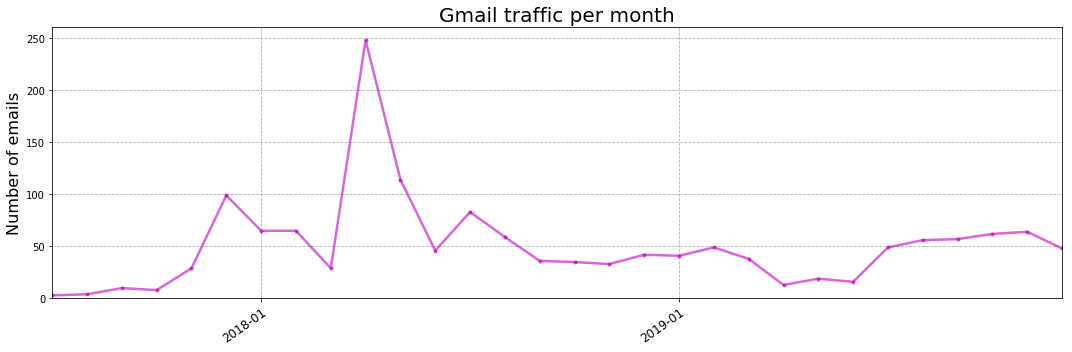

In [18]:
# plot the counts per month
fig = plt.figure(figsize=[15, 5])
ax = month_counts.plot(kind='line', linewidth=2.5, alpha=0.6, color='m', marker='.', markeredgecolor='m')

ax.set_ylim(bottom=0)
ax.grid(True, linestyle='--')
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Gmail traffic per month', fontproperties=title_font)

fig.tight_layout()
fig.savefig('gmail-traffic-month.png', dpi=96)
plt.show()

### Plot the Gmail traffic by the day of the week

In [19]:
# get the count per day of the week
day_counts = pd.DataFrame()
day_counts['count'] = date_counts
day_counts['day_of_week'] = date_counts.index.map(lambda x: parse_datetime(x).weekday())
mean_day_counts = day_counts.groupby('day_of_week')['count'].mean()
xlabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

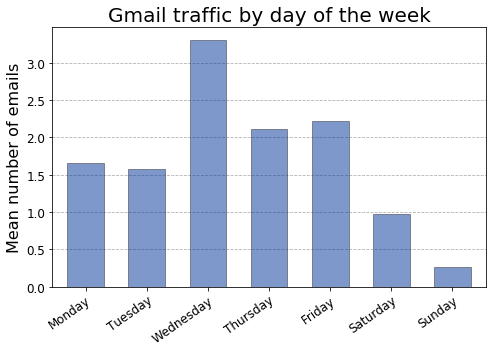

In [20]:
fig = plt.figure(figsize=[7, 5])
ax = mean_day_counts.plot(kind='bar', width=0.6, alpha=0.5, 
                          color='#003399', edgecolor='#333333', zorder=2)

ax.yaxis.grid(True, linestyle='--')
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Gmail traffic by day of the week', fontproperties=title_font)
ax.set_xlabel('')
ax.set_ylabel('Mean number of emails', fontproperties=label_font)

fig.tight_layout()
fig.savefig('gmail-traffic-day-week.png', dpi=96)
plt.show()

### Plot the Gmail traffic by the hour of the day¶

In [21]:
# get the count per hour of the day
times = pd.Series(all_times).map(lambda x: '{:02}:00'.format(parse_datetime(x).hour))
time_counts = times.value_counts().sort_index()
time_counts.head()

00:00    36
01:00    11
02:00    17
03:00    15
04:00    50
dtype: int64

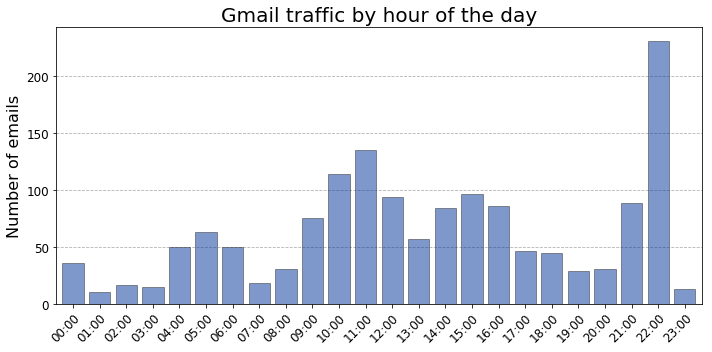

In [22]:

fig = plt.figure(figsize=[10, 5])
ax = time_counts.plot(kind='bar', width=0.8, alpha=0.5, color='#003399', edgecolor='#333333', zorder=2)

ax.yaxis.grid(True, linestyle='--')
ax.set_xticklabels(time_counts.index, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Gmail traffic by hour of the day', fontproperties=title_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)

fig.tight_layout()
fig.savefig('gmail-traffic-hour.png', dpi=96)
plt.show()

### Plot the Gmail traffic by the minute of the day¶

In [23]:
# get the count per minute of the day, as hh:mm
minutes = pd.Series(all_times).map(lambda x: '{:02}:{:02}'.format(parse_datetime(x).hour, parse_datetime(x).minute))
minute_counts = minutes.value_counts().sort_index()

In [24]:
# not every minute necessarily has a message, so fill in missing times with zeros
time_range = pd.date_range(start='0:00', end='23:59', freq='1min')
index = time_range.map(lambda x: '{:02}:{:02}'.format(x.hour, x.minute))
minute_counts = minute_counts.reindex(index, fill_value=0)

In [25]:
# create a series of labels for the plot: each new hour
xlabels = pd.Series([label if ':00' in label else None for label in minute_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]

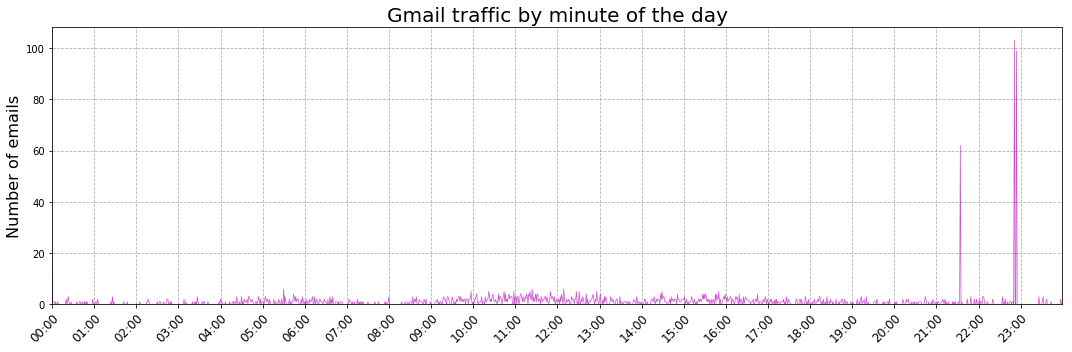

In [26]:

# plot the counts per minute
fig = plt.figure(figsize=[15, 5])
ax = minute_counts.plot(kind='line', linewidth=0.7, alpha=0.7, color='m')

ax.set_ylim(bottom=0)
ax.grid(True, linestyle='--')
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', 
                   ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Gmail traffic by minute of the day', 
             fontproperties=title_font)

fig.tight_layout()
fig.savefig('gmail-traffic-minute.png', dpi=96)
plt.show()

# The following dataset has the data regarding goods sales,mode of transport,product details etc.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [64]:
df = pd.read_excel("Files/Superstore.xls")
df.sample(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
4270,4271,CA-2015-166975,2015-11-26,2015-11-30,Standard Class,SH-20635,Stefanie Holloman,Corporate,United States,Jackson,...,38301,South,FUR-FU-10003930,Furniture,Furnishings,Howard Miller 12-3/4 Diameter Accuwave DS Wal...,692.472,11,0.2,190.4298
4125,4126,CA-2017-123239,2017-07-27,2017-07-31,Second Class,MG-18145,Mike Gockenbach,Consumer,United States,Jacksonville,...,32216,South,FUR-FU-10001602,Furniture,Furnishings,"Eldon Delta Triangular Chair Mat, 52"" x 58"", C...",91.032,3,0.2,-2.2758
8205,8206,CA-2015-114811,2015-11-08,2015-11-08,Same Day,KD-16495,Keith Dawkins,Corporate,United States,New York City,...,10024,East,FUR-CH-10003746,Furniture,Chairs,Hon 4070 Series Pagoda Round Back Stacking Chairs,577.764,2,0.1,115.5528
8080,8081,CA-2015-150714,2015-10-26,2015-11-01,Standard Class,KH-16690,Kristen Hastings,Corporate,United States,Springfield,...,97477,West,OFF-LA-10001474,Office Supplies,Labels,Avery 477,146.544,6,0.2,47.6268
4144,4145,CA-2017-112725,2017-01-30,2017-02-06,Standard Class,EH-14125,Eugene Hildebrand,Home Office,United States,San Francisco,...,94110,West,OFF-AR-10001227,Office Supplies,Art,Newell 338,8.820,3,0.0,2.3814


In [30]:
df.shape

(9994, 21)

In [31]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [38]:
furniture = df.loc[df['Category'] == 'Furniture']  #calling the Furniture data from category column
furniture

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
23,24,US-2017-156909,2017-07-16,2017-07-18,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,...,19140,East,FUR-CH-10002774,Furniture,Chairs,"Global Deluxe Stacking Chair, Gray",71.3720,2,0.30,-1.0196
24,25,CA-2015-106320,2015-09-25,2015-09-30,Standard Class,EB-13870,Emily Burns,Consumer,United States,Orem,...,84057,West,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,1044.6300,3,0.00,240.2649
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.4300,7,0.50,-1665.0522
29,30,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-FU-10004848,Furniture,Furnishings,"Howard Miller 13-3/4"" Diameter Brushed Chrome ...",124.2000,3,0.20,15.5250
36,37,CA-2016-117590,2016-12-08,2016-12-10,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",190.9200,5,0.60,-147.9630


In [39]:
furniture['Order Date'].min(), furniture['Order Date'].max() # calling minmum and maximum date

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [40]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
        'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 
        'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date') 
# droping rest of the columns except Order Date ,Sales.
furniture.isnull().sum() # checking for null values

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Order Date    0
Sales         0
dtype: int64

In [45]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index() 
#   the sum of sales  according to Order  Date
furniture

,Order Date,Sales
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
5,2014-01-14,61.9600
6,2014-01-16,127.1040
7,2014-01-19,181.4700
8,2014-01-20,1413.5100
9,2014-01-21,25.2480


In [46]:
furniture = furniture.set_index('Order Date') # setting OrderDate as index
furniture

,Sales
Order Date,
2014-01-06,2573.8200
2014-01-07,76.7280
2014-01-10,51.9400
2014-01-11,9.9400
2014-01-13,879.9390
2014-01-14,61.9600
2014-01-16,127.1040
2014-01-19,181.4700
2014-01-20,1413.5100


In [47]:
#furniture sales using OrderDates monthly wise
y = furniture['Sales'].resample('M').sum() 
# resampling the sales from days to months
y

Order Date
2014-01-31     6242.5250
2014-02-28     1839.6580
2014-03-31    14573.9560
2014-04-30     7944.8370
2014-05-31     6912.7870
2014-06-30    13206.1256
2014-07-31    10821.0510
2014-08-31     7320.3465
2014-09-30    23816.4808
2014-10-31    12304.2470
2014-11-30    21564.8727
2014-12-31    30645.9665
2015-01-31    11739.9416
2015-02-28     3134.3740
2015-03-31    12499.7830
2015-04-30    10475.6985
2015-05-31     9374.9505
2015-06-30     7714.1790
2015-07-31    13674.4200
2015-08-31     9638.5922
2015-09-30    26273.0230
2015-10-31    12026.6235
2015-11-30    30880.8325
2015-12-31    23085.8192
2016-01-31     7622.7430
2016-02-29     3925.5510
2016-03-31    12801.0920
2016-04-30    13212.0900
2016-05-31    15119.8350
2016-06-30    13070.5720
2016-07-31    13068.5190
2016-08-31    12483.2323
2016-09-30    27262.8809
2016-10-31    11872.5770
2016-11-30    31783.6288
2016-12-31    36678.7150
2017-01-31     5964.0320
2017-02-28     6866.3374
2017-03-31    10893.4448
2017-04-30    

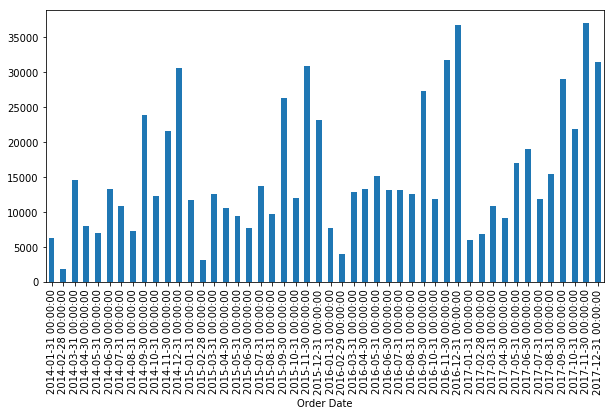

In [48]:
y.plot(kind="bar",figsize=(10,5))

In [49]:
x = furniture['Sales'].resample('Q').sum()
# resampled Sales from days to Quarterly
x

Order Date
2014-03-31    22656.1390
2014-06-30    28063.7496
2014-09-30    41957.8783
2014-12-31    64515.0862
2015-03-31    27374.0986
2015-06-30    27564.8280
2015-09-30    49586.0352
2015-12-31    65993.2752
2016-03-31    24349.3860
2016-06-30    41402.4970
2016-09-30    52814.6322
2016-12-31    80334.9208
2017-03-31    23723.8142
2017-06-30    45032.1030
2017-09-30    56283.1020
2017-12-31    90348.2500
Freq: Q-DEC, Name: Sales, dtype: float64

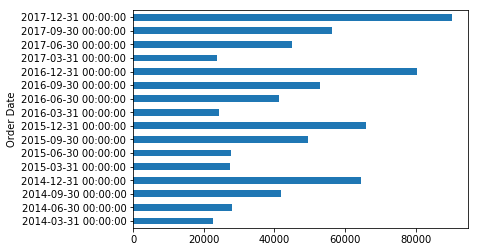

In [50]:
x.plot(kind = 'barh')

In [51]:
#furniture salesusing OrderDate yearly.
v = furniture['Sales'].resample('Y').sum() # resampled Quantity from days to Years
v

Order Date
2014-12-31    157192.8531
2015-12-31    170518.2370
2016-12-31    198901.4360
2017-12-31    215387.2692
Freq: A-DEC, Name: Sales, dtype: float64

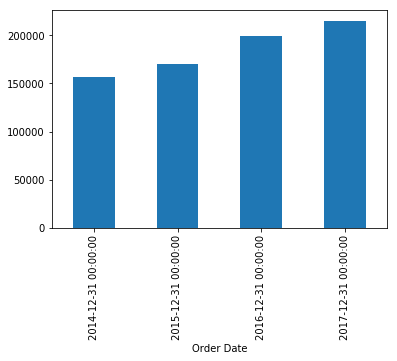

In [52]:
v.plot(kind = "bar")

In [53]:
furniture = df.loc[df['Category'] == 'Furniture'] 
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode','Sales', 
        'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 
        'Sub-Category', 'Product Name','Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date') 
# droping rest of the columns except Quantity,Order Date
furniture.isnull().sum() # checking for null values

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Order Date    0
Quantity      0
dtype: int64

In [54]:
furniture = furniture.groupby('Order Date')['Quantity'].sum().reset_index() 
# here we are adding Quantity in the base of order date
furniture

,Order Date,Quantity
0,2014-01-06,9
1,2014-01-07,3
2,2014-01-10,1
3,2014-01-11,2
4,2014-01-13,9
5,2014-01-14,4
6,2014-01-16,6
7,2014-01-19,5
8,2014-01-20,15
9,2014-01-21,3


In [55]:
furniture = furniture.set_index('Order Date')
furniture

,Quantity
Order Date,
2014-01-06,9
2014-01-07,3
2014-01-10,1
2014-01-11,2
2014-01-13,9
2014-01-14,4
2014-01-16,6
2014-01-19,5
2014-01-20,15


In [56]:
#furniture quantity using order date(monthly).
z = furniture['Quantity'].resample('M').sum() # resampled Quantity from days to months

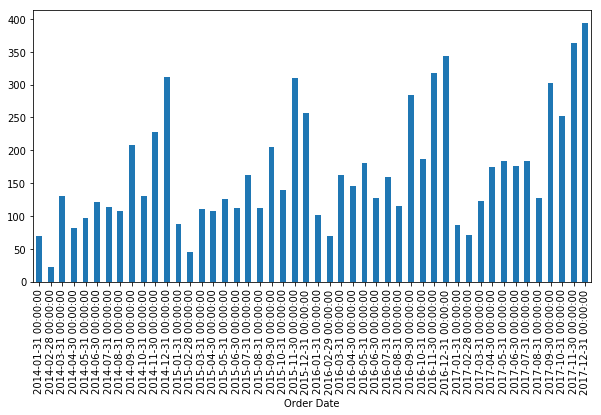

In [57]:
z.plot(kind = 'bar',figsize=(10,5))

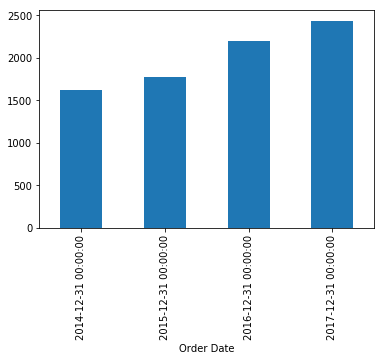

In [58]:
y = furniture['Quantity'].resample('Y').sum()
y.plot(kind = 'bar')

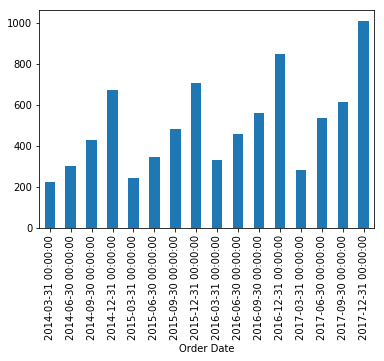

In [59]:
e = furniture['Quantity'].resample('Q').sum()
e.plot(kind = 'bar')

In [60]:

# sales according to Category
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
        'Customer ID','Sub-Category', 'Customer Name', 'Segment', 
        'Country', 'City', 'State', 'Order Date', 'Region', 'Product ID',
        'Product Name', 'Postal Code', 'Discount', 'Profit','Quantity']
df.drop(cols, axis=1, inplace=True)
caty=df.groupby("Category").count()
caty

,Sales
Category,
Furniture,2121
Office Supplies,6026
Technology,1847


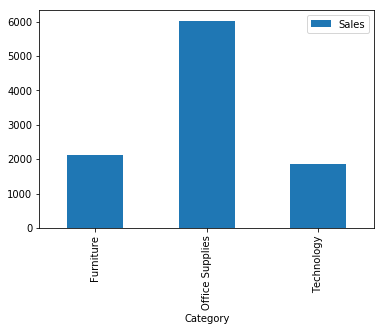

In [61]:
caty.plot(kind = 'bar')

In [63]:
df

,Category,Sales
0,Furniture,261.9600
1,Furniture,731.9400
2,Office Supplies,14.6200
3,Furniture,957.5775
4,Office Supplies,22.3680
5,Furniture,48.8600
6,Office Supplies,7.2800
7,Technology,907.1520
8,Office Supplies,18.5040
9,Office Supplies,114.9000


In [65]:
# sales according to Sub-catogery
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
        'Customer Name', 'Segment', 'Country', 'City', 'State', 'Order Date', 
        'Region', 'Product ID',  'Category', 'Product Name', 'Postal Code', 
        'Discount', 'Profit','Quantity']
df.drop(cols, axis=1, inplace=True)
subcaty=df.groupby("Sub-Category").count()

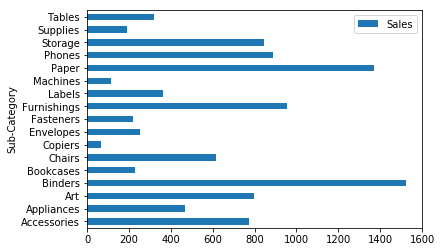

In [66]:
subcaty.plot(kind = 'barh')